![](./images/pytorch-logo.png)

# PyTorch Tutorial

## Outline:

1. Overview of Deep Learning Frameworks
2. PyTorch Under the Hood
3. Exploring PyTorch API by Building an Image Classifer

# 1 - Overview of Deep Learning Frameworks

<img src="./images/frameworks.png?arg" alt="Drawing" style="width: 640px;"/>

Unique mentions of deep learning frameworks in arxiv papers (full text) over time, based on 43K ML papers from 01/2012 to 02/2018:
![](./images/papercite.jpeg?arg)


Some motivation to continue this tutorial:
<img src="./images/fun.png" alt="Drawing" style="width: 720px;"/>

# 2 - PyTorch Under the Hood

## PyTorch:  A Superset of NumPy

### Tensor: A generalization of scalar, vector and matrix to n-dimensions

<img src="./images/tensor.png?arg" alt="Drawing" style="width: 640px;"/>

Tensor implementation in Numpy(np.ndarray) & PyTorch(torch.tensor): all elements in a tensor are in one single data type - Why?

### NumPy: A python library to manipulate tensors

In [13]:
import numpy as np

a = np.array([[1,2,3],[4,5,6]], dtype=np.float)
b = np.array(2, dtype=np.float)
c = a + b
d = c[:, [0, 2]]
assert d.shape == (2, 2)
e = d @ np.random.normal(size=(2, 2))

print("numpy ndarray: {}, type: {}, shape: {}".format(type(e), e.dtype, e.shape))

numpy ndarray: <class 'numpy.ndarray'>, type: float64, shape: (2, 2)


How to do these operations in PyTorch?

In [14]:
import torch

a = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float)
b = torch.tensor(2, dtype=torch.float)
c = a + b
d = c[:, [0, 2]]
assert d.shape == (2, 2)
e = d @ torch.randn(2, 2, dtype=torch.float)

print("torch tensor: {}, type: {}, shape: {}".format(type(e), e.dtype, e.shape))

torch tensor: <class 'torch.Tensor'>, type: torch.float32, shape: torch.Size([2, 2])


torch.tensor and np.ndarry has very similar: friendly to NumPy users :)

You can convert np.ndarray to torch.tensor and vice versa:

In [17]:
a = torch.ones(2, 2)
b = a.numpy()
print(type(a), type(b))

c = np.ones(5)
d = torch.from_numpy(c)
print(type(c), type(d))

<class 'torch.Tensor'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'torch.Tensor'>


Why do I wanna do this?
* Already have many code written in NumPy
* Want to extend the PyTorch library using NumPy

The best part: there is almost no overhead (5$\mu$s) no matter how large your tensor is!
<img src="./images/convert.png?arg" alt="Drawing" style="width: 320px;"/>

How can this be done?
<img src="./images/ndarray-tensor.png?arg" alt="Drawing" style="width: 320px;"/>

Let's prove it in the code:

In [27]:
a = torch.ones(2, 2)
b = a.numpy()

b += 1 # in-place operation
print(a)

c = torch.from_numpy(b)
c.mul_(5) # in-place operation
print(b)

print("data address of a:", a.storage().data_ptr())
print("data address of c:", c.storage().data_ptr())

tensor([[2., 2.],
        [2., 2.]])
[[10. 10.]
 [10. 10.]]
data address of a: 140368218834816
data address of c: 140368218834816


## Beyond NumPy: GPU Accelerate

Tensors are default living in CPU, but they can be moved to GPU several simple lines of code:

In [28]:
x = torch.randn((2, 2))
y = torch.randn((2, 2))
print(x.device, y.device)
if torch.cuda.is_available():
    x = x.cuda() # move to gpu
    y = y.cuda() # move to gpu
z = x + y
print(z, z.device)

cpu cpu
tensor([[1.4312, 1.5242],
        [1.5099, 2.3998]]) cpu


Or simply once for all:

In [29]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
x = torch.randn((2, 2), device=dev)  # create in cpu/gpu
y = torch.randn((2, 2)).to(x.device) # create in cpu & move to cpu/gpu
z = x + y
print(z, z.device)

tensor([[-1.2971, -0.3420],
        [ 0.4912, -2.1065]]) cpu


## Beyond NumPy: Automatic Differentiation

Backpropagation is a simple but powerful method to train aritificial neural network followed by gradient descent.

Just like other popular DL frameworks, PyTorch adpots reverse-mode automatic differentiation to implement backpropagation. They all build a computational graph and computes gradient of each parameter using the chain rule.

Take $y = \textbf{w}^T\textbf{x} + b$ for example:

<img src="./images/bp.png?arg" alt="Drawing" style="width: 320px;"/>

### Compute Gradient in PyTorch
Let's see how to compute gradient in PyTorch.

AD related properties in torch.Tensor:

| Name | Description |
| :------: | :------: |
| requires_grad | default: False |
| is_leaf | requires_grad=False or created by user |
| grad | accumulated gradient, need to be reset after each iteration |
| grad_fn | the Function that created the tensor |

Call backward() on a torch.Tensor to compute it's gradient:

In [54]:
x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

# y = torch.mm(w.t(), x) + b
t = torch.mm(w.t(), x)
y = t + b

print('x: require_grad: {}, grad: {}, grad_fn: {}, is_leaf: {}'.format(x.requires_grad, x.grad, x.grad_fn, x.is_leaf))
print('w: require_grad: {}, grad: {}, grad_fn: {}, is_leaf: {}'.format(w.requires_grad, w.grad, w.grad_fn, w.is_leaf))
print('b: require_grad: {}, grad: {}, grad_fn: {}, is_leaf: {}'.format(b.requires_grad, b.grad, b.grad_fn, b.is_leaf))
print('t: require_grad: {}, grad: {}, grad_fn: {}, is_leaf: {}'.format(t.requires_grad, t.grad, t.grad_fn, t.is_leaf))
print('y: require_grad: {}, grad: {}, grad_fn: {}, is_leaf: {}'.format(y.requires_grad, y.grad, y.grad_fn, y.is_leaf))

# w.register_hook(lambda grad: print('dtdw:', grad))
# b.register_hook(lambda grad: print('dydb:', grad))
# t.register_hook(lambda grad: print('dydt:', grad))
# y.register_hook(lambda grad: print('dydy:', grad))

y.backward()
print('w.grad=', w.grad)
print('b.grad=', b.grad)
print('x.grad=', x.grad)

x: require_grad: False, grad: None, grad_fn: None, is_leaf: True
w: require_grad: True, grad: None, grad_fn: None, is_leaf: True
b: require_grad: True, grad: None, grad_fn: None, is_leaf: True
t: require_grad: True, grad: None, grad_fn: <MmBackward object at 0x11c2d9da0>, is_leaf: False
y: require_grad: True, grad: None, grad_fn: <AddBackward0 object at 0x11c2d9f28>, is_leaf: False
w.grad= tensor([[1.],
        [2.]])
b.grad= tensor([1.])
x.grad= None


**Memory is a scarce resource**:

Only leaf node's grad will be kept. Call retain_grad() to keep grad for non-leaf nodes:

In [57]:
x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

# y = torch.mm(w.t(), x) + b
t = torch.mm(w.t(), x)
y = t + b

# t.retain_grad()
y.backward()
print('t.grad=', t.grad)

t.grad= None


**Memory is a scarce resource**:

Intermediate data will be released right after the usage during backprop. Set retain_graph=True to keep the buffer:

In [61]:
x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

# y = torch.mm(w.t(), x) + b
t = torch.mm(w.t(), x)
y = t + b

# y.backward(retain_graph=True)
y.backward()
print('w.grad=', w.grad)
print('b.grad=', b.grad)

print('===second time backward===')
y.backward()
print('w.grad=', w.grad)
print('b.grad=', b.grad)

w.grad= tensor([[1.],
        [2.]])
b.grad= tensor([1.])
===second time backward===
w.grad= tensor([[2.],
        [4.]])
b.grad= tensor([2.])


**Memory is a scarce resource**:

Avoid using in-place operations in forward pass!

In [70]:
x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

# y = torch.mm(w.t(), x) + b
t = torch.mm(w.t(), x) # dtdw = x
y = t + b

x += 3
# x = x + 3

y.backward()
print('w.grad=', w.grad)
print('b.grad=', b.grad)

w.grad= tensor([[1.],
        [2.]])
b.grad= tensor([1.])


### Eager Mode & Script Mode

Now let's see what happens when we run the code(eager):
![](./images/eager.gif?arg)

Dynamic & Imperative: run immediately when encounter (build a new graph each time)

Pros:
* Flexible
* Pythonic
* Easy to debug

Cons:
* Hard to optimize
* Significant overhead
* Hard to deploy

To overcome these drawbacks, PyTorch 1.0 introduced TorchScript, which can convert PyTorch code to serializable and optimizable IR format. There are two ways to translate eager code to script mode:

* Tracing
* Scripting

#### Tracing

In [89]:
def trace_foo(x, w, b):
    return torch.mm(w.t(), x) + b

x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

tmodule = torch.jit.trace(trace_foo, (x, w, b)) # compile

x1 = torch.Tensor([[3], [6]])
w1 = torch.Tensor([[1], [2]]).requires_grad_()
b1 = torch.Tensor([4]).requires_grad_()

y = tmodule.forward(x1, w1, b1)

y.backward()
print('w1.grad=', w1.grad)
print('b1.grad=', b1.grad)

w1.grad= tensor([[3.],
        [6.]])
b1.grad= tensor([1.])


Easy and straight forward! Train and debug the model in eager mode and convert it with a dummy input.

However it will only record the operations triggered by the input:

In [98]:
def trace_foo(x, w, b):
    if x.mean() > 0:
        return torch.mm(w.t(), x) + b
    else:
        return torch.mm(w.t(), x) - b

x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

tmodule = torch.jit.trace(trace_foo, (x, w, b)) # compile

x1 = torch.Tensor([[-3], [-6]])
w1 = torch.Tensor([[1], [2]]).requires_grad_()
b1 = torch.Tensor([4]).requires_grad_()

y = tmodule.forward(x1, w1, b1)

y.backward()
print('b1.grad=', b1.grad) # Error!

print(tmodule.graph)

b1.grad= tensor([1.])
graph(%x : Float(2, 1),
      %w : Float(2, 1),
      %b : Float(1)):
  %6 : Float(1!, 2) = aten::t(%w)
  %7 : Float(1, 1) = aten::mm(%6, %x)
  %8 : int = prim::Constant[value=1]()
  %9 : Float(1, 1) = aten::add(%7, %b, %8)
  return (%9)



/Users/momo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  


#### Scripting

In [107]:
@torch.jit.script
def script_foo(x, w, b):
    if x.mean() > 0:
        return torch.mm(w.t(), x) + b
    else:
        return torch.mm(w.t(), x) - b

x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

y = script_foo(x, w, b)

y.backward()
print('b.grad=', b.grad)

x1 = torch.Tensor([[-3], [-6]])
w1 = torch.Tensor([[1], [2]]).requires_grad_()
b1 = torch.Tensor([4]).requires_grad_()

y = script_foo(x1, w1, b1)

y.backward()
print('b1.grad=', b1.grad) # Right!

print(script_foo.graph)

b.grad= tensor([1.])
b1.grad= tensor([-1.])
graph(%x : Tensor,
      %w : Tensor,
      %b : Tensor):
  %9 : int = prim::Constant[value=1]()
  %4 : int = prim::Constant[value=0]()
  %3 : Tensor = aten::mean(%x)
  %5 : Tensor = aten::gt(%3, %4)
  %6 : bool = prim::Bool(%5)
  %15 : Tensor = prim::If(%6)
    block0():
      %7 : Tensor = aten::t(%w)
      %8 : Tensor = aten::mm(%7, %x)
      %10 : Tensor = aten::add(%8, %b, %9)
      -> (%10)
    block1():
      %11 : Tensor = aten::t(%w)
      %12 : Tensor = aten::mm(%11, %x)
      %14 : Tensor = aten::sub(%12, %b, %9)
      -> (%14)
  return (%15)



This is how script mode looks like:
![](./images/script.gif?arg)

It will first compile the whole graph and then feed the input into it. Optimization can be easily done with all the information about the graph. You can reuse the same graph until you detach the output from it.

In [77]:
@torch.jit.script
def script_foo(x, w, b):
    return torch.mm(w.t(), x) + b

x = torch.Tensor([[1], [2]])
w = torch.Tensor([[5], [7]]).requires_grad_()
b = torch.Tensor([-1]).requires_grad_()

y = script_foo(x, w, b)

y.backward()
print('w.grad=', w.grad)
print('b.grad=', b.grad)

y.backward()
print('w.grad=', w.grad)
print('b.grad=', b.grad)

# y.detach_()
# y.backward()
# print('w.grad=', w.grad)
# print('b.grad=', b.grad)

w.grad= tensor([[1.],
        [2.]])
b.grad= tensor([1.])
w.grad= tensor([[2.],
        [4.]])
b.grad= tensor([2.])


## Beyond Numpy: High Level APIs & Utilities for DL

* torch.nn
* torch.optim
* torch.utils.data
* torchvision

# 3 - Exploring PyTorch API (Demo)

Let's build an image classifier using the MNIST dataset!

## 1. Prepare the data

The MNIST database of handwritten digits has a training set of 60,000 examples and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

We can easily download and prepare the data using the package torchvision, which consists of popular datasets, model architectures, and common image transformations for computer vision.

In [112]:
import random
import torchvision

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

print(trainset)
print(testset)

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None
Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None


You can also define your own dataset using `torch.utils.data.Dataset`.

We usually need to use SGD to train the model since the whole training set is usually too large. In each iteration, we need to fetch a batch (randomly chosen sample) from the dataset. `torch.utils.data.DataLoader` is responsible for managing batches.

In [115]:
from torch.utils.data import DataLoader

def _worker_init_fn_():
        torch_seed = torch.initial_seed()
        np_seed = torch_seed // (2**32 -1)
        random.seed(torch_seed)
        np.random.seed(np_seed)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=_worker_init_fn_())
testloader = DataLoader(testset, batch_size=500, shuffle=False, num_workers=4)

Let's take a look at the data:

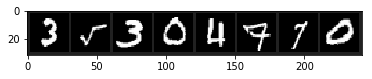

Labels:    3   5   3   0   4   7   7   0


In [119]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    img = img * 0.3081 + 0.1307
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()

# get some random images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:8]))
# print labels
print('Labels:', ''.join('%4d' % j.item() for j in labels[:8]))

## 2. Define the model

![](./images/cnn.png?arg)

`torch.nn.Module` is a base class for all neural network modules. It can track all the parameters and status. We need to define our model as a subclass of it and overide the `__init__()` and `forward()` method. We can define our module by using the submodules that `torch.nn` has already provided, like Convolution Layer, Linear Layer, Pooling Layer and Dropout Layers...:

In [120]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fnn = nn.Sequential(
            nn.Linear(7*7*64, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.convnet(x)
        x = x.view(-1, 7*7*64)
        x = self.fnn(x)
        return x    

net = Net().to(device)

## 3. Define Loss

`torch.nn` package also provides a bunch of common loss functions, here we use cross entropy loss:

In [123]:
criterion = nn.CrossEntropyLoss() # softmax + nll!

## 4. Define Optimization Method

`torch.optim` is a package implementing various optimization algorithms:

In [121]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 5. Train

Let's see how these components work together:

In [131]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients: set all parameter tensors's grad to 0
        optimizer.zero_grad()

        # forward: build the backward graph
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # backward: compute gradients
        loss.backward()
        
        # gradient descent: update all parameter tensors with its grad
        optimizer.step()

        # print loss
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.202
[1,   200] loss: 0.191
[1,   300] loss: 0.163
[1,   400] loss: 0.155
[1,   500] loss: 0.151
[1,   600] loss: 0.138
[1,   700] loss: 0.134
[1,   800] loss: 0.118
[1,   900] loss: 0.107
Finished Training


## 6. Test

Let's test our model's performance:

In [132]:
correct = 0
total = 0

# no graph need to be build here
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


Let's see some test result:

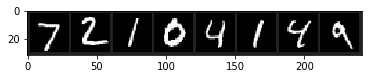

Ground Truth    7   2   1   0   4   1   4   9
Prediction    7   2   1   0   4   1   4   9


In [134]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:8]))
print('Ground Truth', ''.join('%4d' % j.item() for j in labels[:8]))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Prediction', ''.join('%4d' % j.item() for j in predicted[:8]))

# Takeaways

PyTorch = NumPy + GPU + AD Engine + DL APIs & Utilities 